In [268]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import accuracy_score, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import warnings

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings('ignore')
from sklearn import linear_model

In [269]:
import numpy as np
from annoy import AnnoyIndex

def find_knn(data, query_point, k, metric='euclidean'):
  """Finds the K nearest neighbors of a query point in a dataset.

  Args:
    data: A NumPy array representing the dataset.
    query_point: A NumPy array representing the query point.
    k: The number of nearest neighbors to find.
    metric: The distance metric to use ('euclidean', 'angular', etc.).

  Returns:
    A tuple containing two NumPy arrays:
      - The indices of the K nearest neighbors in the dataset.
      - The distances to the K nearest neighbors.
  """

  num_dimensions = data.shape[1]
  index = AnnoyIndex(num_dimensions, metric)

  for i, point in enumerate(data):
    index.add_item(i, point)

  index.build(10)  # Build the index with 10 trees (adjust as needed)

  indices = index.get_nns_by_vector(query_point, k, include_distances=False)

  return indices

## Prediction algorithms

In [317]:


  
def predpy(algo, X_train, y_train, X_test,params={"m":1, "nepochs":100}):
    m=1
    nepochs=100
    yhat=0
    
    if "m" in params:
        m=params["m"]

    if "nepochs" in params:
        nepochs=params["nepochs"]

    Nts=X_test.shape[0]
    n=X_train.shape[1]
    if algo=="lazy_regr0":

        k = 5  # Find the 5 nearest neighbors
        yhat=np.zeros(Nts)
        for i in np.arange(Nts):
            indices = find_knn(X_train, X_test[i,:], k)
            yhat[i]=np.mean(y_train[indices])
            
    if algo=="lazy_regr":
        from sklearn.linear_model import LassoCV
        k = 3*n  
        yhat=np.zeros(Nts)
        #selected_features = mrmr_regression(pd.DataFrame(X_train), y_train, K=5)
        #X_train=X_train[:,selected_features]
        #X_test=X_test[:,selected_features]
        for i in np.arange(Nts):
            indices = find_knn(X_train, X_test[i,:], k)
            Xl=X_train[indices,:]
            Yl=y_train[indices]
            reg = LassoCV(cv=2, random_state=0).fit(Xl, Yl)
        
            yhat[i] = reg.predict(X_test[i,:].reshape(1,-1))
            
    
    if algo=="keras0_regr":
        from tensorflow import keras 
        from tensorflow.keras import layers
        def build_model():
          model = keras.Sequential([              
              layers.Dense(4, activation="relu"),
              layers.Dropout(0.95),
              layers.Dense(2, activation="relu"),
              layers.Dense(m)
          ])
          model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
          return model
        model = build_model()                                
        model.fit(X_train, y_train,                 
                epochs=nepochs, batch_size=10, verbose=0, validation_split=0.2)

        yhat=model.predict(X_test)
    
    if algo=="keras_regr":
    # Based on Keras Tuner
    ## https://keras.io/keras_tuner/
    ##  https://www.tensorflow.org/tutorials/keras/keras_tuner
        from tensorflow import keras 
        from tensorflow.keras import layers
        import keras_tuner as kt
        import tensorflow as tf
        def model_builder(hp):
              model = keras.Sequential()
              # Tune the number of units in the first Dense layer
              # Choose an optimal value between 32-512
              hp_units = hp.Int('units', min_value=1, max_value=20, step=1)
              model.add(keras.layers.Dense(units=hp_units, activation='relu'))
              hp_units2 = hp.Int('units2', min_value=2, max_value=10, step=2)
              model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
              hp_droprate = hp.Choice('droprate', values=[0.1, 0.5, 0.7, 0.9])
              model.add(keras.layers.Dropout(hp_droprate))
              model.add(keras.layers.Dense(m))

              model.compile(optimizer="rmsprop",
                          loss="mse",
                          metrics=['accuracy'])

              return model

        tuner = kt.Hyperband(model_builder,
                           objective='val_accuracy',
                           max_epochs=10,
                           factor=3)

        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        tuner.search(X_train, y_train,
          epochs=50, validation_split=0.2, callbacks=[stop_early],verbose=0)

        # Get the optimal hyperparameters
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)
        history =model.fit(X_train, y_train,epochs=nepochs, batch_size=10, 
          validation_split=0.25, verbose=0)

        #val_acc_per_epoch = history.history['val_accuracy']
        #best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1                              
        #hypermodel = tuner.hypermodel.build(best_hps)
        # Retrain the model
        #hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2,verbose=0)
        yhat=model.predict(X_test)
    
    
    if algo=="pls_regr":
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import RandomizedSearchCV
        random_grid = {'n_components': [int(x) for x in np.linspace(1, 20, num = 15)]}
        reg = PLSRegression()

        pls_regressor = RandomizedSearchCV(estimator = reg, param_distributions = random_grid,
        n_iter = 70, cv = 3, verbose=0, random_state=42)

        pls_regressor.fit(X_train, y_train)
        yhat = pls_regressor.predict(X_test)
    
    if algo=="ridge_regr":
        from sklearn.linear_model import RidgeCV

        reg = RidgeCV(alphas=np.linspace(0.1, 100, num = 50))
        reg.fit(X_train, y_train)
        yhat = reg.predict(X_test)

    
    if algo=="lasso_regr":  
        from sklearn.linear_model import LassoCV, MultiTaskLassoCV
        if m==1:
          reg = LassoCV(cv=10, random_state=0).fit(X_train, y_train)
        else:
          reg = MultiTaskLassoCV(cv=2, random_state=0,max_iter=10,
          verbose=0).fit(X_train, y_train)
        yhat = reg.predict(X_test)
    
    if algo=="enet_regr":  
        from sklearn.linear_model import ElasticNet, MultiTaskElasticNet
        from sklearn.model_selection import RandomizedSearchCV

        if m==1:
          reg = ElasticNet(random_state=0).fit(X_train, y_train)
        else:
          random_grid = {'alpha': [int(x) for x in np.linspace(0.1, 2, num = 10)]}
          reg =MultiTaskElasticNet()
          reg = RandomizedSearchCV(estimator = reg, param_distributions = random_grid,
          n_iter = 50, cv = 3, verbose=0, random_state=42)
          reg.fit(X_train, y_train)

        yhat = reg.predict(X_test)
    
    
    
    if algo=="lin_regr":
        # Create linear regression object
        from sklearn import linear_model
        linear_regressor = linear_model.LinearRegression()
        linear_regressor.fit(X_train, y_train)
        yhat = linear_regressor.predict(X_test)
  
    if algo=="rf_regr0":
        from sklearn.ensemble import RandomForestRegressor
        #from sklearn.model_selection import GridSearchCV
        from sklearn.model_selection import RandomizedSearchCV

        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]

        # Create the random grid
        random_grid = {'max_depth': max_depth}
        #             'min_samples_split': min_samples_split,
        #               'min_samples_leaf': min_samples_leaf}
        rf_r = RandomForestRegressor()
        rf_regressor = RandomizedSearchCV(estimator = rf_r, param_distributions = random_grid,
          n_iter = 5, cv = 3, verbose=0, random_state=42)
        rf_regressor =rf_r
        rf_regressor.fit(X_train, y_train)
        yhat = rf_regressor.predict(X_test)
  
    if algo=="rf_regr":
        from sklearn.ensemble import RandomForestRegressor
        #from sklearn.model_selection import GridSearchCV
        from sklearn.model_selection import RandomizedSearchCV
        rf_r = RandomForestRegressor()
        #if m>1:
        #  from sklearn.multioutput import RegressorChain
        #  rf_r = RegressorChain(base_estimator=rf_r, order='random')
        rf_regressor =rf_r

        rf_regressor.fit(X_train, y_train)

        yhat = rf_regressor.predict(X_test)
    
   
    if algo=="knn_regr":
        from sklearn.neighbors import KNeighborsRegressor
        from sklearn.model_selection import RandomizedSearchCV

        # Create the random grid
        random_grid = {'n_neighbors': [int(x) for x in np.linspace(3, 20, num = 10)],
                  'weights':['uniform', 'distance']}
        knn_r = KNeighborsRegressor()

        knn_regressor = RandomizedSearchCV(estimator = knn_r, param_distributions = random_grid,
        n_iter = 50, cv = 3, verbose=0, random_state=42)
        knn_regressor.fit(X_train, y_train)
        yhat = knn_regressor.predict(X_test)
    
    if algo=="gb_regr":
        from sklearn.ensemble import GradientBoostingRegressor
        from sklearn.model_selection import RandomizedSearchCV
        if m>1:
          #from sklearn.multioutput import MultiOutputRegressor
          #gb_regressor = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=5))
          from sklearn.multioutput import RegressorChain
          gb_regressor = RegressorChain(base_estimator=GradientBoostingRegressor(), order='random')
          random_grid = {'base_estimator__n_estimators': [int(x) for x in np.linspace(1, 20, num = 5)]}
        else:
          gb_regressor = GradientBoostingRegressor()
          random_grid = {'n_estimators': [int(x) for x in np.linspace(1, 20, num = 5)]}

        gb_regressor = RandomizedSearchCV(estimator = gb_regressor, param_distributions = random_grid,
        n_iter = 20, cv = 2, verbose=0, random_state=42)

        gb_regressor.fit(X_train, y_train)

        yhat = gb_regressor.predict(X_test)
   
    
    if algo=="ab_regr":
        from sklearn.ensemble import AdaBoostRegressor
        from sklearn.tree import DecisionTreeRegressor
        if m>1:
          from sklearn.multioutput import MultiOutputRegressor
          ab_regressor = MultiOutputRegressor(AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), 
            n_estimators=400, random_state=7))
          random_grid = {'estimator__base_estimator__max_depth': [int(x) for x in np.linspace(1, 10, num = 5)]}
        else:
          ab_regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=400, random_state=7)
          random_grid = {'base_estimator__max_depth': [int(x) for x in np.linspace(1, 10, num = 5)]}

        ab_regressor = RandomizedSearchCV(estimator = ab_regressor, param_distributions = random_grid,
        n_iter = 20, cv = 2, verbose=0, random_state=42)

        ab_regressor.fit(X_train, y_train)
        yhat = ab_regressor.predict(X_test)
    
  
  
    
    if algo=="piperf_regr":  
        from sklearn.pipeline import Pipeline
        from sklearn.feature_selection import SelectFromModel
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.multioutput import RegressorChain
        #if m>1:
        #  clf = Pipeline([
        #  ('feature_selection', SelectFromModel(RandomForestRegressor())),
        #  ('regression', RegressorChain(base_estimator=RandomForestRegressor(), order='random'))
        #  ])
        #else:
        clf = Pipeline([
          ('feature_selection', SelectFromModel(RandomForestRegressor())),
          ('regression', RandomForestRegressor())
          ])
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)
    
    if algo=="pipeknn_regr":  
        from sklearn.pipeline import Pipeline
        from sklearn.feature_selection import SelectFromModel
        from sklearn.neighbors import KNeighborsRegressor
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.model_selection import RandomizedSearchCV
        knn_r = Pipeline([
          ('feature_selection', SelectFromModel(RandomForestRegressor())),
          ('regression', KNeighborsRegressor())
        ])
        random_grid = {'feature_selection__max_features': [int(x) for x in np.linspace(1, 10, num = 5)],
        'regression__n_neighbors': [int(x) for x in np.linspace(1, 20, num = 5)]}
        knn_regressor = RandomizedSearchCV(estimator = knn_r, param_distributions = random_grid,
        n_iter = 20, cv = 2, verbose=0, random_state=42)
        knn_regressor.fit(X_train, y_train)
        yhat = knn_regressor.predict(X_test)
    
    if algo=="pipelin_regr":  
        clf = Pipeline([
          ('reduce_dim', PCA()),
          ('feature_selection', SelectFromModel(RandomForestRegressor())),
          ('regression', linear_model.LinearRegression())
        ])
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)

    
    if algo=="pipeab_regr":  
        clf = Pipeline([
          ('feature_selection', SelectFromModel(RandomForestRegressor())),
          ('regression', AdaBoostRegressor(n_estimators=500))
        ])
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)

        yhat.shape=(int(Nts),int(m))
    
    
    if algo=="torch_regr":

        # Convert to PyTorch tensors
        X_trainT = torch.tensor(X_train, dtype=torch.float32)
        y_trainT = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Unsqueeze for shape
        X_testT = torch.tensor(X_test, dtype=torch.float32)

        train_dataset = TensorDataset(X_trainT, y_trainT)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_dataset = TensorDataset(X_testT)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 2. Define the Neural Network Model:
        class RegressionModel(nn.Module):
            def __init__(self, input_size, hidden_size, output_size):
                super(RegressionModel, self).__init__()
                self.fc1 = nn.Linear(input_size, hidden_size)
                self.relu = nn.ReLU()
                self.fc1a = nn.Linear(hidden_size, hidden_size)
                self.fc2 = nn.Linear(hidden_size, output_size)

            def forward(self, x):
              out = self.fc1(x)
              out = self.relu(out)
              #out = self.fc1a(out)
              #out = self.relu(out)
              out = self.fc2(out)
              return out

        # Instantiate the model
        input_size = X_trainT.shape[1]  # Number of features
        hidden_size = 12  # Adjust as needed
        output_size = m   # For regression
        model = RegressionModel(input_size, hidden_size, output_size)


        optimizer = optim.Adam(model.parameters())
        criterion = nn.MSELoss()  # Mean Squared Error for regression

      # Training loop
        epochs = nepochs  # Adjust as needed
    
        for epoch in range(epochs):
          for batch_idx, (data, target) in enumerate(train_loader):
              optimizer.zero_grad()
              output = model(data)
              loss = criterion(output, target)
              loss.backward()
              optimizer.step()
          #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        model.eval()  # Set the model to evaluation mode
        yhat=[]
        #import pdb
        with torch.no_grad():  # Don't calculate gradients during evaluation
          total_loss = 0
          for data in test_loader:
              #pdb.set_trace()  
              output = model(data[0])
              yhat=np.append(yhat,output.numpy())
          


    if type(yhat)==int:
        print(algo)
        raise ValueError("Method not present")
    return yhat  


## Embedding function

In [318]:
def Embed(tseries,lag=[2,2],H=1):
    m=tseries.shape[1]
    X=None
    lagM=np.max(lag)
    for j in np.arange(m):
        Embed = np.lib.stride_tricks.sliding_window_view(tseries[:,j], window_shape=lagM+H)
        if X is None:
            X=Embed[:,(lagM-lag[j]):lagM]
            Y=Embed[:,-H:]
        else:
            
            X = np.column_stack((X, Embed[:,(lagM-lag[j]):lagM]))
            Y=np.column_stack((Y, Embed[:,-H:]))
    
    
    return X,Y


## Inverse control algorithm

In [376]:

def incontr(regressor, iregressor, yref,ynow,unow,XX,YY,u0,maxR=200):
    
    R=maxR
    minE=1000   
    
    yy=ynow+unow+yref.tolist()
    q=np.array(yy)
    q=q.reshape(1,-1)
    bestu=iregressor.predict(q) 

    for r in np.arange(R):       
        if np.random.rand(1)<0.25 and r >10:
            ur=ur+0.15*es
        else:
            ur=bestu+0.05*np.random.randn(1)
        ur=float(ur)
        yy=ynow+unow+[ur]
        q=np.array(yy)
        q=q.reshape(1,-1)
        
        yhat=regressor.predict(q)      
        E=np.mean((yref-yhat)**2)
        if (E < minE):
            minE=E
            bestu=ur
            k=20
            q=np.array(yy)
            indices = find_knn(XX, q, k)
            Xl=XX[indices,:]
            Yl=YY[indices,0]
            reg = LinearRegression().fit(Xl, Yl)
            yhat = reg.predict(q.reshape(1,-1))
            p=reg.coef_[-1]
        
            es=((yref[0]-yhat)*p)[0]

            
            #print(minE)
        if (minE< 0.001):
            break;
    return bestu
    

### Lazy inverse control

In [377]:
def incontr2( regr,yref,ynow,unow,XX,YY,u0):
    
    R=100
    minE=1000   
    bestu=u0
    k=10
    es=1
    ur=u0
    for r in np.arange(R):       
        if np.random.rand(1)<0.5 and r >10:
            ur=ur+0.15*es
        else:
            ur=bestu+0.15*np.random.randn(1)
        
        yy=ynow+unow+[float(ur)]
        q=np.array(yy)
        #q=q.reshape(1,-1)
        indices = find_knn(XX, q, k)
        Xl=XX[indices,:]
        Yl=YY[indices]
        reg = LinearRegression().fit(Xl, Yl)
        yhat = reg.predict(q.reshape(1,-1))
        p=reg.coef_[-1]
        
        es=((yref-yhat)*p)[0]
        
        
        E=(yref-yhat)**2
        if (E < minE):
            minE=E
            bestu=ur
            #print(minE)
        if (minE< 0.0001):
            break;
    return float(bestu)

# ML Control

In [378]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
print("python-control", ct.__version__)

python-control 0.10.1


## Dynamical system

### Narendra 2

In [379]:


def nar2_update(t, x, u, params):
    # wheelbase
    return np.array([
        (x[0]/(1+x[0]**2)+1)*np.sin(x[1]),  ## x[0]=x1(k)
        x[1]*np.cos(x[1])+x[0]*np.exp(- (x[0]**2+x[1]**2)/8) +u[0]**3/(1+u[0]**2+0.5*np.cos(x[0]+x[1]))    ## x[1]=x(k-1)
    ])          
def nar2_output(t, x, u, params):
    sdy = params['sdy'] ## stdev noise output
    return x[0]/(1+0.5 *np.sin(x[1]))+x[1]/(1+0.5 *np.sin(x[0]))+sdy*np.random.randn(1)   # x, y position



### Narendra 3

In [449]:
# n_states=2

def nar3_update(t, x, u, params):
   
    x0plus= x[0]/(1+x[0]**2)+u[0]**3
    x1plus=x[0]
    return np.array([x0plus, x1plus])   

def nar3_output(t, x, u, params):
    sdy = params['sdy'] ## stdev noise output
    return x[0]+sdy*np.random.randn(1)   # x, y position

nstates=2


### Narendra 4

In [381]:
# n_states=5

def nar4_update(t, x, u, params):
    return np.array([
        x[0]*x[1]*x[2]*(x[2]-1)*x[4]+u[0]/(1+x[1]**2+x[2]**2),  ## x[0]=y(k)
        x[0],  ## y(k-1) 
        x[1],  ## y(k-2)
        u[0],  ## u(k-1)
        x[3] ## u(k-2)
          
    ])          
def nar4_output(t, x, u, params):
    return x[0]   # x, y position

nstates=5


## System definition

In [450]:
dT=1

nar = ct.nlsys(
    nar3_update, nar3_output, states=nstates, inputs=1, outputs=1,
    dt=dT, params={'sdx': 0.01,'sdy': 0.01 })


namefile="NAR3.npz"

## Initialization dataset with P controller

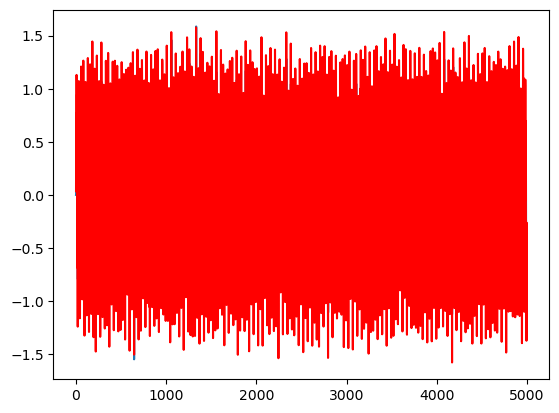

In [451]:

nsteps=5000
T=nsteps*dT

timepts = np.arange(0, T,dT)

sequence = (-1,-1,-1,-1,-1,0,0,0,0, 1,1,1,1,1, 2,2, 1,1, 0, 0, -1,-1,-1)
uu =  [k for j in range(1000) for k in sequence]
yref=0.1*np.array(uu[:len(timepts)])
#yref=0.3*np.random.randn(len(timepts))
yref=0.15*np.sin(2*np.pi*timepts/55)+0.75*np.sin(2*np.pi*timepts/25)+0.5*np.sin(2*np.pi*timepts/5)+0.1*np.random.randn(len(timepts))


## step by step proportional control 
X0=[0,0] ## initial state
x=np.array(X0).reshape(-1,1)
K=0.88 ## proportional control constant
y=[0]
Yh=[]
Uh=[]
Yh.append(y[-1])
for tt in np.arange(nsteps-1):
    uu=K*(yref[tt]-y[-1])
    (t,y,x) = ct.input_output_response( nar, np.array([0,1]) , uu,  return_x=True,X0=x[:,-1]) 
    
    Yh.append(y[-1])
    Uh.append(uu)

plt.plot(Yh)
plt.plot(yref,'r')


## Historical data embedding

In [452]:
L=len(Uh)
print(Yh[:5])
print(Uh[:5])
D=np.vstack((Yh[:L],Uh[:L])).T
D.shape
H=2 ## prediction horizon
lagy=6
lagu=3
XX,YY=Embed(D,lag=[lagy,lagu],H=H)

IXX=np.hstack((XX[:,:-1],YY[:,:H]))
IYY=XX[:,-1]
              
np.savez(namefile, XX=XX, YY=YY, IXX=IXX, IYY=IYY)
print(XX[:3,:])
print(YY[:3,:])


[0, 0.008254185024892443, 0.23357317164250999, 0.3259450773110862, 0.2910768202925864]
[0.03044948464721392, 0.6156572798916325, 0.4729291824479001, -0.10304172449075737, -0.18727927504373362]
[[ 0.          0.00825419  0.23357317  0.32594508  0.29107682  0.25714783
  -0.10304172 -0.18727928  0.67287196]
 [ 0.00825419  0.23357317  0.32594508  0.29107682  0.25714783  0.56100354
  -0.18727928  0.67287196  0.50095675]
 [ 0.23357317  0.32594508  0.29107682  0.25714783  0.56100354  0.55655122
   0.67287196  0.50095675  0.450231  ]]
[[ 0.56100354  0.55655122  0.50095675  0.450231  ]
 [ 0.55655122  0.51807797  0.450231    0.1255774 ]
 [ 0.51807797  0.41405463  0.1255774  -0.09059058]]


## Prediction accuracy assessment

In [453]:


N,n=XX.shape
Ntr=int(2*N/3)
print(N)
for h in np.arange(H):
    Xtr=XX[:Ntr,:]
    Ytr=YY[:Ntr,h]
    Xts=XX[Ntr:,:]
    Yts=YY[Ntr:,h]

    IXtr=IXX[:Ntr,:]
    IYtr=IYY[:Ntr]
    IXts=IXX[Ntr:,:]
    IYts=IYY[Ntr:]
    E=Yts-predpy("rf_regr",Xtr,Ytr,Xts)
    IE=IYts-predpy("rf_regr",IXtr,IYtr,IXts)
    print(E.shape)
    print("h=",h,":",np.mean(E**2)/np.var(Yts),np.mean(IE**2)/np.var(IYts))

4992
(1664,)
h= 0 : 0.002962686438754547 0.038017453023365566
(1664,)
h= 1 : 0.0548610943120105 0.0378284261975766


## Comparison of proportional vs ML inverse control

In [462]:

def saturate (u,up=3,low=-3):
    return(np.max((np.min((u,up)),low)))

reuse=True
nsteps=50000
T=nsteps*dT
timepts = np.arange(0, T,dT)

yref=np.concatenate((np.repeat(0,10),(np.repeat(1,20))))

subsample=1 ## the larger the smaller the dataset

### ML control


data = np.load(namefile)
XX=data["XX"]
YY=data["YY"]
IXX=data["IXX"]
IYY=data["IYY"]
    

print("XX.shape=",XX.shape,XX[::subsample,:].shape)
#
# Create the random grid
#random_grid = {'n_neighbors': [int(x) for x in np.linspace(150, 200, num = 10)],
#          'weights':['uniform', 'distance']}
#knn_r = KNeighborsRegressor()
#regressor = RandomizedSearchCV(estimator = knn_r, param_distributions = random_grid,
#    n_iter = 50, cv = 5, verbose=0, random_state=42)
#gb_regressor = GradientBoostingRegressor()
#random_grid = {'n_estimators': [int(x) for x in np.linspace(1, 20, num = 5)]}
#gb_regressor = RandomizedSearchCV(estimator = gb_regressor, param_distributions = random_grid,
#    n_iter = 20, cv = 2, verbose=0, random_state=42)

#regressor =gb_regressor
#regressor = LassoCV(cv=10, random_state=0)
#random_grid = {'n_components': [int(x) for x in np.linspace(1, 20, num = 15)]}
#reg = PLSRegression()
#regressor = RandomizedSearchCV(estimator = reg, param_distributions = random_grid,
#        n_iter = 70, cv = 3, verbose=0, random_state=42)
#regressor = linear_model.LinearRegression()
#regressor = Pipeline([ ('feature_selection', SelectFromModel(RandomForestRegressor(),max_features=3)),  ('regression', RandomForestRegressor())
#          ])

regressor = RandomForestRegressor()
iregressor=RandomForestRegressor()
regressor.fit(XX[::subsample,:],YY[::subsample,H-1]) ## multi-output regression
iregressor.fit(IXX[::subsample,:],IYY[::subsample])




X0=[0,0] ## initial state
x=np.array(X0).reshape(-1,1)
K=0.3 ## proportional control constant
y=[0]
Y=[]
U=[]
Y.append(y[-1])
prevu=0
lastt=3
for tt in np.arange(nsteps-1):
    if tt>=len(yref)-5:
        if np.random.rand()<0.5:
            yref= np.concatenate((yref,0.75*np.repeat(np.random.randn(1),np.random.choice(range(15, 20))) ))
        else:
            yref= np.concatenate((yref,0.75*np.sin(2*np.pi*np.arange(5,25)*np.random.uniform(0.02, 0.03, 1))))
        print("len(yref)=",len(yref))
    if tt> lagy and np.mod(tt,2)==0:
        print(tt)
        print("MSE ML=", np.mean((Y[1:tt]-yref[1:tt])**2)/np.var(yref[1:tt]))
    uu=K*(yref[tt]-y[-1])
    if tt> lagy:
        ynow=Y[-lagy:]
        unow=U[-lagu+1:]
        if lagu==1:
            unow=[]
        
        uu=incontr(regressor,iregressor, yref[tt:tt+H],ynow,unow,XX,YY,u0=prevu,maxR=500)
        
    uu=saturate(uu)
    U.append(uu)
    
    prevu=uu
    (t,y,x) = ct.input_output_response( nar, np.array([0,1]) , uu,  return_x=True,X0=x[:,-1]) 
    Y.append(y[-1])
    

    ## online learning
    deltaL=50
    safe=2
    if  tt>10 and (np.mod(tt,deltaL)==0 or np.abs(y[-1])>safe or np.abs(Y[tt]-yref[tt])>safe/2):
        
        L=len(U)

        ## use only recent observations
        oD=np.vstack((Y[np.min((lastt,L-20)):L],U[np.min((lastt,L-20)):L])).T

        lastt=tt

        oXX,oYY=Embed(oD,lag=[lagy,lagu],H=H)
        XX=np.vstack((XX,oXX))
        YY=np.vstack((YY,oYY))

        regressor.fit(XX[::subsample,:],YY[::subsample,H-1])

        IXX=np.vstack((IXX,np.hstack((oXX[:,:-1],oYY[:,:H]))))
        IYY=np.vstack((IYY.reshape(-1,1),oXX[:,-1].reshape(-1,1)))
        iregressor.fit(IXX[::subsample,:],IYY[::subsample])
        print("Dataset XX.shape=",XX.shape)
        np.savez(namefile, XX=XX, YY=YY, IXX=IXX, IYY=IYY)

print("MSE ML=", np.mean((Y[1:tt]-yref[1:tt])**2)/np.var(yref[1:tt]))

plt.plot(Y[1:])
plt.plot(yref,'r')



XX.shape= (5430, 9) (5430, 9)
8
MSE ML= inf
10
MSE ML= inf
12
MSE ML= 0.5586294790191656
14
MSE ML= 0.33200871688047384
16
MSE ML= 0.2560515301295074
18
MSE ML= 0.21817560188345578
20
MSE ML= 0.19599884453117816
22
MSE ML= 0.1963940425754736
24
MSE ML= 0.1984615859805139
len(yref)= 48
26
MSE ML= 0.19306437169561477
28
MSE ML= 0.1926468381606202
30
MSE ML= 0.1867430527273349
32
MSE ML= 0.32587882636316384
34
MSE ML= 0.320748642429964
36
MSE ML= 0.31659203381209594
38
MSE ML= 0.3129968370826717
40
MSE ML= 0.30970894115152775
42
MSE ML= 0.30682245439543415
len(yref)= 68
44
MSE ML= 0.3045298353481987
46
MSE ML= 0.302737688316766
48
MSE ML= 0.30050921010529
50
MSE ML= 0.30117470819003256
Dataset XX.shape= (5471, 9)
52
MSE ML= 0.30022858538461655
54
MSE ML= 0.298338583250451
56
MSE ML= 0.2981820298492196
58
MSE ML= 0.2992678413294185
60
MSE ML= 0.2984170526499001
62
MSE ML= 0.2911482679166953
len(yref)= 88
64
MSE ML= 0.27128991308007533
66
MSE ML= 0.24019686511677868
68
MSE ML= 0.22042568253

484
MSE ML= 0.19042658772075977
486
MSE ML= 0.19043295066388172
len(yref)= 513
488
MSE ML= 0.19069832519756635
490
MSE ML= 0.19082326549880016
492
MSE ML= 0.19053981988812185
494
MSE ML= 0.19350170734231886
496
MSE ML= 0.19430918516921028
498
MSE ML= 0.19374274414061254
500
MSE ML= 0.19316273652654053
Dataset XX.shape= (5873, 9)
502
MSE ML= 0.1927434426817674
504
MSE ML= 0.19268530548923513
506
MSE ML= 0.19300588262266152
len(yref)= 532
508
MSE ML= 0.19332036749120957
510
MSE ML= 0.19319039334664503
512
MSE ML= 0.192470977698573
514
MSE ML= 0.19140647298878327
516
MSE ML= 0.1904189321886245
518
MSE ML= 0.18946494867595806
520
MSE ML= 0.1885227978452435
522
MSE ML= 0.1876621674737171
524
MSE ML= 0.18675660701132177
526
MSE ML= 0.1859784151142731
len(yref)= 551
528
MSE ML= 0.18518352389028617
530
MSE ML= 0.18430996363211258
532
MSE ML= 0.18354533035532844
534
MSE ML= 0.18291640948365234
Dataset XX.shape= (5902, 9)
536
MSE ML= 0.18347933034769534
Dataset XX.shape= (5915, 9)
538
MSE ML= 0.

KeyboardInterrupt: 

### Visualization results

MSE ML= 0.19072832767595632


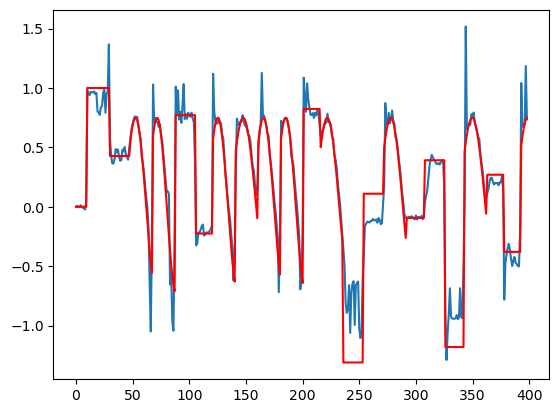

In [464]:
np.savez(namefile, XX=XX, YY=YY, IXX=IXX, IYY=IYY)
N0=1
N=400
print("MSE ML=", np.mean((Y[N0:N]-yref[N0:N])**2)/np.var(yref[N0:N]))
plt.plot(Y[N0:N])
plt.plot(yref[N0-1:N-1],'r')

In [458]:
oD.shape

(5, 2)

## Proportional control

MSE P= 0.9021830250843561


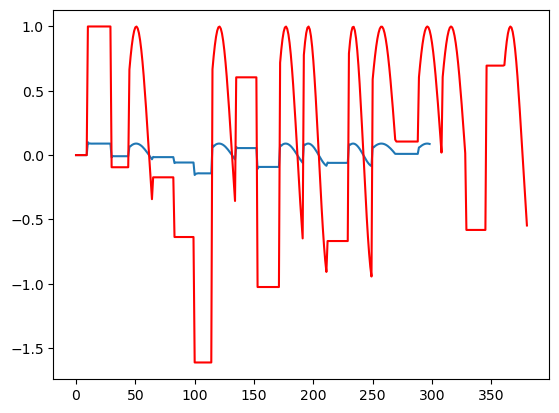

In [335]:
nsteps=300
y=[0]
Y=[]
U=[]
X0=[0,0] ## initial state
x=np.array(X0).reshape(-1,1)
Y.append(y[-1])
K=0.1
for tt in np.arange(nsteps-1):
    
    uu=K*(yref[tt]-y[-1])
    U.append(uu)
    (t,y,x) = ct.input_output_response( nar, np.array([0,1]) , uu,  return_x=True,X0=x[:,-1]) 
    Y.append(y[-1])
    
    
print("MSE P=",np.mean((Y[1:]-yref[:nsteps-1])**2)/np.var(yref[:-1]))
plt.plot(Y[1:])
plt.plot(yref,'r')

In [333]:
tt

381